In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import lmdb
import pickle
from collections import defaultdict

import sys
import pathlib
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

In [ ]:
# Store image path and labels as a dataframe (from LMDB file)
# DATA_DIR = pathlib.Path(sys.path[0]).parents[0] / "data"
# IMG_DIR = DATA_DIR / "local_subset" 
# RAW_DS_PATH = DATA_DIR / "data_dict_val.pkl"

# if RAW_DS_PATH.exists():
#     val_raw_ds = pickle.load(open(RAW_DS_PATH.as_posix(), 'rb'))
# else:
#     # TODO: test get_labels_dict function
#     print("Error: this raw dataset does not exist. Try extracting from the LMDB.")

In [3]:
# Collect list of image paths with valid labels (from image directory path)
def get_valid_paths(img_dir, raw_ds):
    valid_ids = list(raw_ds)
    paths = [p.as_posix() for p in IMG_DIR.rglob('*.jpg')]
    print("# original images: ", len(paths))
    paths = [p for p in paths if p.split('/')[-1] in valid_ids]
    print("# valid labeled images: ", len(paths))
    return paths

# ex_path_ds = get_valid_paths(IMG_DIR, val_raw_ds)
# print(ex_path_ds[0])

In [31]:
# Generate dataframes of images and raw labels (from list of image paths)
def resize_img(img, fixed_size):
    w = img.shape[0]
    h = img.shape[1]
    scale = fixed_size / max(w,h)
    
    seq = iaa.Sequential([
        iaa.Resize(float(scale)),
        iaa.CenterPadToFixedSize(height=fixed_size, width=fixed_size)
    ])
    img = seq(image=img)    
    return img

def process_path(path, raw_ds):
    # Get Label
    key = path.split('/')[-1]
    ingr_ids, class_id, nsteps = raw_ds[key]
    
    # Get image with max dim of 512
    img = imageio.imread(path)
    img = resize_img(img, 512)
    return img, ingr_ids, class_id, nsteps

# out = map(lambda p: process_path(p, val_raw_ds), ex_path_ds) # parallelizable?
# out = np.array(list(out))
# ex_imgs = out[:,0]
# ex_ingr_ids = out[:,1]
# ex_class_ids = out[:,2]
# ex_nsteps = out[:,3]

# # Check data generation
# for i, img in enumerate(ex_imgs):
#     print("Image shape", img.shape)
#     print("Ingr ids", ex_ingr_ids[i])
#     print("Class id", ex_class_ids[i])
#     print("# recipe steps", ex_nsteps[i])
#     ia.imshow(img)
#     break

In [5]:
# Build class ids dictionary
# CLASS_PATH = DATA_DIR / "classes1M.pkl"
# with open(CLASS_PATH, 'rb') as f:
#     imid2clid = pickle.load(f) # image_id to class_id dict
#     id2class = pickle.load(f) # class_id to class_name dict

# One hot encode class ids
def encode_class(class_ids, id2class):
    nclasses = len(list(id2class))
    nsamples = len(class_ids)
    one_hot = np.zeros((nsamples, nclasses))
    
    for i, class_id in enumerate(class_ids):
        one_hot[i][class_id-1] = 1 # adjustment for 1-indexed ids
    return one_hot

# ex_class_labels = encode_class(ex_class_ids, id2class)

In [ ]:
# Inspect distribution of classes
# fig, axs = plt.subplots(1,2, figsize=(20,10))
# axs[0].hist(imid2clid.values())
# axs[0].set_title("Frequency of class ids (0 is background)")

# axs[1].hist(list(filter(lambda x: x != 0, imid2clid.values())))
# axs[1].set_title("Frequency of class ids without background")

In [6]:
# Build recipe words id dictionary
# RVOCAB_PATH = DATA_DIR / "vocab.txt"
# with open(RVOCAB_PATH) as f_vocab:
#     id2rvocab = {i+2: w.rstrip() for i, w in enumerate(f_vocab)}
#     id2rvocab[1] = '</i>'
# rvocab2id = {v:k for k,v in id2rvocab.items()}
    
# Extract list of unique recipe word ids representing ingredients
def find_unique_ingr_ids(raw_ds_list, invalid_ids):
    # Aggregate unique ids
    unique_ids = set()
    for ds in raw_ds_list:
        ingr_ds = np.array(list(ds.values()))[:,0] # extracting ingr ids from dict of img id : raw labels
        for ids in ingr_ds:
            nids = np.where(ids == 1)[0][0]
            unique_ids.update(ids[:nids])
    
    # Discard invalid ids
    for ingr_id in invalid_ids:
        unique_ids.remove(ingr_id)
         
    # Convert set to np array
    unique_ids = np.array(list(unique_ids))
    return unique_ids

# Build ingredients id dictionary
def build_ingr_id_dict(ingr_ids, id2rvocab):
    id2ingr = defaultdict(lambda:-1) # this default value allows for invalid key checking
    rid2iid = defaultdict(lambda:-1)
    for iid, rid in enumerate(ingr_ids):
        ingr_word = id2rvocab[rid]
        id2ingr[iid] = ingr_word
        rid2iid[rid] = iid
    return id2ingr, rid2iid

# invalid_ingr_names = ['Ingredients', '1', '100', '2', '200', '23', '30', '300', \
#                '4', '450', '50', '500', '6', '600']
# invalid_ids = [rvocab2id[n] for n in invalid_ingr_names]
# raw_ds_list = [val_raw_ds] # TODO: add test_raw_ds
# unique_ids = find_unique_ingr_ids(raw_ds_list, invalid_ids)
# id2ingr, rid2iid = build_ingr_id_dict(unique_ids, id2rvocab)
# print("# unique ingredients:", len(list(id2ingr)))

# Inspect ingredients for invalid ids
# print(sorted(id2ingr.values())[:100])

In [7]:
# One hot encode ingredient ids
def encode_ingrs(ingr_ids_list, rid2iid):
    ningrs = len(list(rid2iid))
    nsamples = len(ingr_ids_list)
    one_hot = np.zeros((nsamples, ningrs))
    
    for i, ingr_ids in enumerate(ingr_ids_list):
        for rid in ingr_ids:
            if rid == 1: # stop token
                break
            iid = rid2iid[rid]
            if iid != -1: # checks if id found in dict (and thus a valid ingr)
                one_hot[i][iid] = 1
    return one_hot

# ex_ingr_labels = encode_ingrs(ex_ingr_ids, rid2iid)
# print("Check counts equal to ")
# print(np.sum(ex_ingr_labels, axis=1)[[1,5]])
# print(ex_ingr_ids[[1,5]])

# Print all example ingredient words to spot invalid ingredients 
# and check the encoding function correctly excludes it
# for ingr_ids in ex_ingr_ids:
#     print([id2rvocab[rid] for rid in ingr_ids if rid > 1])

In [32]:
# Take image dir and load images, labels for train and val = encapsulate all above logic = util.load_data
# TODO: adapt to multi-task, currently single task (food class)
# TODO: train-val split
DATA_DIR = pathlib.Path(sys.path[0]).parents[0] / "data"
IMG_DIR = DATA_DIR / "local_subset" 
ID_DS_TRAIN_PATH = DATA_DIR / "data_dict_val.pkl"
CLASS_PATH = DATA_DIR / "classes1M.pkl"
RVOCAB_PATH = DATA_DIR / "vocab.txt"

def load_data():
    # Extract image id : raw labels dictionary
    # TODO: include LMDB extraction and test that util fn
    if ID_DS_TRAIN_PATH.exists():
        id_ds_tr = pickle.load(open(ID_DS_TRAIN_PATH.as_posix(), 'rb'))
    else:
        print("Error: this raw dataset does not exist. Try extracting from the LMDB.")
        return
    
    # Get images (resized) and raw labels
    path_ds = get_valid_paths(IMG_DIR, id_ds_tr)
    
    raw_ds = map(lambda p: process_path(p, id_ds_tr), path_ds)
    raw_ds = np.array(list(raw_ds))
    imgs, ingr_ids, class_ids, nsteps = raw_ds[:,0], raw_ds[:,1], raw_ds[:,2], raw_ds[:,3]
    
    # Build class id dictionary
    with open(CLASS_PATH, 'rb') as f:
        imid2clid = pickle.load(f) # image_id to class_id dict
        id2class = pickle.load(f) # class_id to class_name dict
    
    # One hot encode class ids
    class_labels = encode_class(class_ids, id2class)
    
    # Build ingr id dictionary
    with open(RVOCAB_PATH) as f_vocab:
        id2rvocab = {i+2: w.rstrip() for i, w in enumerate(f_vocab)}
        id2rvocab[1] = '</i>'
    rvocab2id = {v:k for k,v in id2rvocab.items()}
    
    invalid_ingr_names = ['Ingredients', '1', '100', '2', '200', '23', '30', '300', \
                   '4', '450', '50', '500', '6', '600']
    invalid_ids = [rvocab2id[n] for n in invalid_ingr_names]
    id_ds_list = [id_ds_tr] # TODO: add id_ds_tr, import in up top
    unique_ids = find_unique_ingr_ids(id_ds_list, invalid_ids)
    id2ingr, rid2iid = build_ingr_id_dict(unique_ids, id2rvocab)
    print("# unique ingredients:", len(list(id2ingr)))
    
    # One hot encode ingr ids
    ingr_labels = encode_ingrs(ingr_ids, rid2iid)
    
    # TODO: Split train and val sets
    return imgs, ingr_labels, class_labels, nsteps

ex_imgs, ex_ingr_labels, ex_class_labels, ex_nsteps = load_data()

# original images:  29
# valid labeled images:  24
# unique ingredients: 3464


In [61]:
ex_imgs = np.stack(ex_imgs).astype(np.int32) # convert each image from object type

Image shape (512, 512, 3)
Ingr ids [1. 0. 0. ... 0. 0. 0.]
Class id [0. 0. 0. ... 0. 0. 0.]
# recipe steps 7


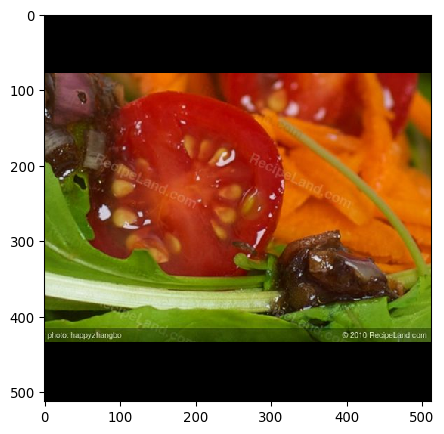

In [35]:
# Check data loading
for i, img in enumerate(ex_imgs):
    print("Image shape", img.shape)
    print("Ingr ids", ex_ingr_labels[i])
    print("Class id", ex_class_labels[i])
    print("# recipe steps", ex_nsteps[i])
    ia.imshow(img)
    break

In [57]:
# Create data generator for augmenting on the fly and batching = model.data_aug() [replace input_fn]
def data_aug(img):
    seq = iaa.Sequential([
        iaa.Cutout()
    ])
    img = seq(image=img)
    return img    


In [62]:
import model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 4
epochs = 10
datagen = ImageDataGenerator(preprocessing_function=data_aug) # Alt: prebatch images and cache, much faster performance
model = model.create_keras_model(input_shape=(224,224,3), 
                                 learning_rate=.01)
history = model.fit_generator(
    datagen.flow(ex_imgs, ex_class_labels, batch_size=batch_size),
    steps_per_epoch=ex_imgs.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(ex_imgs, ex_class_labels)
)

Epoch 1/10
6/6 [==============================] - 6s 1s/step - loss: 0.6934 - accuracy: 0.2917 - val_loss: 0.6933 - val_accuracy: 0.4583
Epoch 2/10
6/6 [==============================] - 5s 816ms/step - loss: 0.6933 - accuracy: 0.4583 - val_loss: 0.6933 - val_accuracy: 0.4583
Epoch 3/10
6/6 [==============================] - 5s 805ms/step - loss: 0.6933 - accuracy: 0.4583 - val_loss: 0.6933 - val_accuracy: 0.4583
Epoch 4/10
6/6 [==============================] - 5s 827ms/step - loss: 0.6933 - accuracy: 0.4583 - val_loss: 0.6933 - val_accuracy: 0.4583
Epoch 5/10
6/6 [==============================] - 5s 810ms/step - loss: 0.6933 - accuracy: 0.4583 - val_loss: 0.6933 - val_accuracy: 0.4583
Epoch 6/10
6/6 [==============================] - 5s 805ms/step - loss: 0.6933 - accuracy: 0.4583 - val_loss: 0.6933 - val_accuracy: 0.4583
Epoch 7/10
6/6 [==============================] - 5s 833ms/step - loss: 0.6933 - accuracy: 0.4583 - val_loss: 0.6933 - val_accuracy: 0.4583
Epoch 8/10
6/6 [=======